# Preface

Here, we will apply some regularization techniques to improve the performance of a classifier on the CIFAR10 dataset. This is a classic dataset for benchmarking deep learning applications, and strikes a nice balance between task difficulty and computational complexity -- it is harder than MNIST/FashionMNIST, and yet much smaller than the ImageNet dataset. Hence, it is widely used for benchmarking.

Here, we will learn how to regularize the models to improve performance.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
sns.set(font_scale=1.5, style='darkgrid')

# The CIFAR10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

![alt text](https://miro.medium.com/max/944/1*6XQqOifwnmplS22zCRRVaw.png "CIFAR10")

More information: https://www.cs.toronto.edu/~kriz/cifar.html

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

169001437/169001437 [==============================] - 6s 0us/step


Since these are RGB images, each sample is going to be of shape [Height, Width, Channels], where the last dimension represents the R, G and B channel of the image. We can still use `plt.imshow` to plot the RGB image.

(50000, 32, 32, 3)


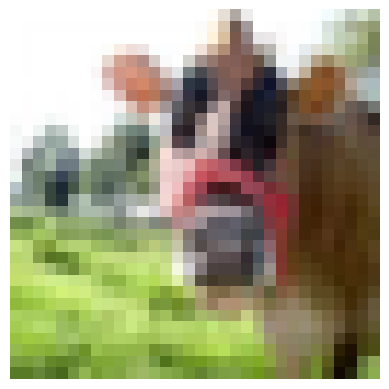

In [ ]:
print(x_train.shape)
with sns.axes_style('white'):
    plt.imshow(x_train[0])
    plt.axis('off')

# Baseline CNN

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tqdm.keras import TqdmCallback

We will build a simple CNN with 3 Conv layers and 3 FC layers.

In [ ]:
model = Sequential()

# Conv 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

# Conv 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 3
model.add(Conv2D(256, (3, 3), activation='relu'))

# FC 1
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# FC 2
model.add(Dense(128, activation='relu'))

# FC 3
model.add(Dense(10))

Let us first fit the model using a "default" way, without any regularizations, and see how is the performance.

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # from_logits=True requires no softmax activation
    metrics=['accuracy'],
)

In [3]:
try:
    history = pd.read_json('cifar10_baseline.json')
    model = tf.keras.models.load_model('cifar10_baseline.h5')
except:    
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)],
    )
    history = pd.DataFrame(history.history) 
    history.to_json('cifar10_baseline.json')
    model.save('cifar10_baseline.h5')

NameError: ignored

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history.plot(y=['loss', 'val_loss'], ax=ax[0])
history.plot(y=['accuracy', 'val_accuracy'], ax=ax[1])
model.evaluate(x_test, y_test)

# Improving the Baseline Model

Let us now improve the model using the techniques we just covered in class. We will employ
  * Dropout
  * Batch Normalization
  * Momentum SGD with a learning rate schedule

In [4]:
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout

In [5]:
model = Sequential()

# Conv 1
model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 2
model.add(Dropout(rate=0.25))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 3
model.add(Dropout(rate=0.25))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 1
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 2
model.add(Dropout(rate=0.5))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 3
model.add(Dropout(rate=0.5))
model.add(Dense(10))

We will use the SGD (with momentum) optimizer using a learning rate schedule. This can be easily done using the `LearningRateScheduler` callback. 

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
def step_decay(epoch):
    """
    Returns the desired learning rate at epoch
    """
    init_lr = 0.01  # initial
    gamma = 0.5  # decay ratio
    k0 = 20  # decay interval
    lr = init_lr * gamma ** np.floor((epoch)/k0)
    return lr

In [ ]:
model.compile(
    optimizer=SGD(momentum=0.95),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
try:
    history = pd.read_json('cifar10_tuned.json')
    model = tf.keras.models.load_model('cifar10_tuned.h5')
except:
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=100,
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[
            TqdmCallback(verbose=1),
            LearningRateScheduler(step_decay, verbose=1)
        ],
    )
    history = pd.DataFrame(history.history)
    history.to_json('cifar10_tuned.json')
    model.save('cifar10_tuned.h5')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history.plot(y=['loss', 'val_loss'], ax=ax[0])
history.plot(y=['accuracy', 'val_accuracy'], ax=ax[1])
model.evaluate(x_test, y_test)

We observe that this has significantly improved performance. In particular, the training/testing performance are now much more similar, as one would expect when successfully regularizing the model.

# Data Augmentation

As a last method, we will use **data augmentation**. The reason we separate this is to show how drastic an effect this has on the model performance. This is almost *universal*, in the sense that no matter what algorithms/architectures we use, with data augmentation we are likely to see a huge increase in testing performance. This is because we built *prior knowledge* into the learning model.

## Only Data Augmentation on Baseline

Here, we will only use data augmentation and see what benefit that brings to our baseline model.

In [11]:
model = Sequential()

# Conv 1
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

# Conv 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 3
model.add(Conv2D(256, (3, 3), activation='relu'))

# FC 1
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# FC 2
model.add(Dense(128, activation='relu'))

# FC 3
model.add(Dense(100))

We can perform data augmentation on-the-fly during training using the `ImageDataGenerator` class. You can find many other options in it by reading its [documentation](https://keras.io/preprocessing/image/).

For this problem we will use
  * Random rotation up to 15 degrees
  * random shift vertically and horizontally by 10%
  * random zoom in and out by 10%
  * random horizontal flips

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    zoom_range=0.1,  # set range for random zoom (1-zoom_range, 1+zoom_range)
    horizontal_flip=True,  # randomly flip images horizontally
)
flow = datagen.flow(x_train, y_train, batch_size=32)

Note that we need to call `fit` on the training set
```python
    datagen.fit(x_train)
```
if some zca_transform or similar whitening approaches are used. Here we don't have to do that.

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
try:
    history = pd.read_json('cifar100_baseline_augment.json')
    model = tf.keras.models.load_model('cifar100_baseline_augment.h5')
except:
    history = model.fit(
        flow,  # Instead of feeding numpy arrays, we feed a generator (in this case, batchsize is not needed)
        epochs=100,
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)],
        workers=4,  # Number of parallel workers for the datagen step (should tune this depending on machine)
    )
    history = pd.DataFrame(history.history)
    history.to_json('cifar100_baseline_augment.json')
    model.save('cifar100_baseline_augment.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: ignored

313/313 [==============================] - 1s 3ms/step - loss: 2.3573 - accuracy: 0.4267


[2.3573288917541504, 0.42669999599456787]

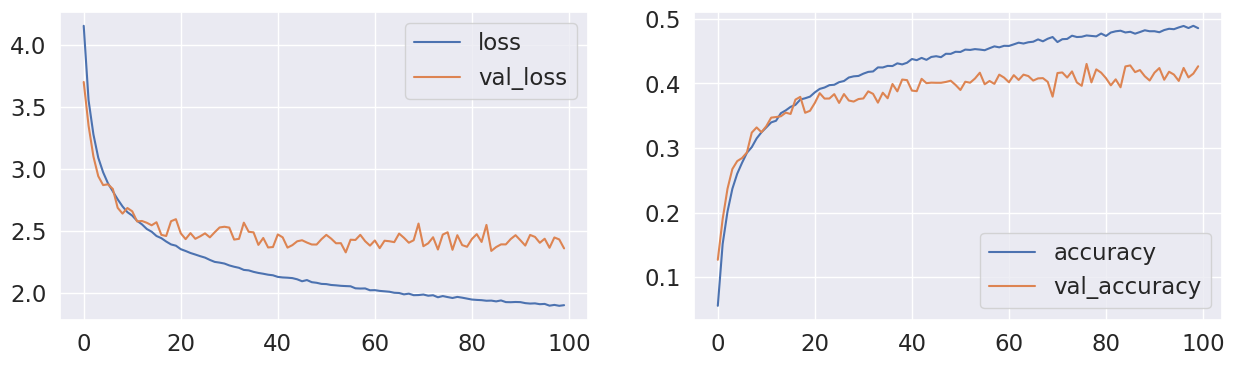

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history.plot(y=['loss', 'val_loss'], ax=ax[0])
history.plot(y=['accuracy', 'val_accuracy'], ax=ax[1])
model.evaluate(x_test, y_test)

In [ ]:
from keras.metrics import top_k_categorical_accuracy

def topKacc(Y_true, Y_pred):
  return top_k_categorical_accuracy(Y_true, Y_pred, k = 5)

In [ ]:
top_k_categorical_accuracy(y_test, model.predict(x_test))

313/313 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)>

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', top_k_categorical_accuracy],
)

Observe that with data augmentation alone, we are able to improve performance drastically!

In [ ]:
model.evaluate(x_test, y_test, verbose=0)


[2.3573288917541504, 0.42669999599456787, 0.7196999788284302]

## Data Augmentation on Regularized Model

Finally, we will combine the regularization techniques with data augmentation.

In [ ]:
model = Sequential()

# Conv 1
model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 2
# model.add(Dropout(rate=0.25))  # We remove dropouts in conv layers to reduce underfitting
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Conv 3
# model.add(Dropout(rate=0.25))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 1
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 2
model.add(Dropout(rate=0.5))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# FC 3
model.add(Dropout(rate=0.5))
model.add(Dense(10))

In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
)
flow = datagen.flow(x_train, y_train, batch_size=128)

In [ ]:
model.compile(
    optimizer=SGD(momentum=0.95),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
try:
    history = pd.read_json('cifar10_tuned_augment.json')
    model = tf.keras.models.load_model('cifar10_tuned_augment.h5')
except:
    history = model.fit(
        flow,
        epochs=100,
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[
            TqdmCallback(verbose=1),
            LearningRateScheduler(step_decay)
        ],
    )
    history = pd.DataFrame(history.history)
    history.to_json('cifar10_tuned_augment.json')
    model.save('cifar10_tuned_augment.h5')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history.plot(y=['loss', 'val_loss'], ax=ax[0])
history.plot(y=['accuracy', 'val_accuracy'], ax=ax[1])
model.evaluate(x_test, y_test)